## Dataset Information

The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

Formally, given a training sample of tweets and labels, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist, your objective is to predict the labels on the test dataset.

For training the models, we provide a labelled dataset of 31,962 tweets. The dataset is provided in the form of a csv file with each line storing a tweet id, its label and the tweet.

## Import modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the dataset

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/training.1600000.processed.noemoticon.csv",header = 0, encoding = 'Latin', engine = 'python')
cols = ['label', 'id', 'date', 'query', 'user','tweet']
dataset.columns = cols


dataset.head()


,label,id,date,query,user,tweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


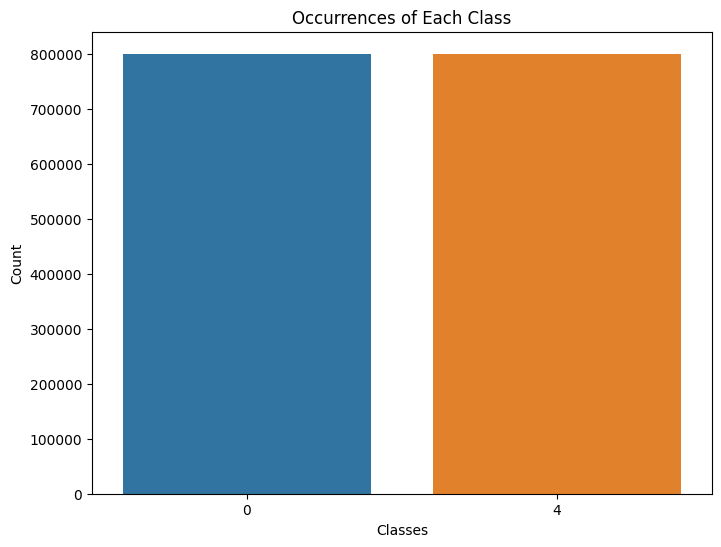

In [ ]:
#Checking balance of dataset
import seaborn as sns


class_counts = dataset['label'].value_counts()


plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Occurrences of Each Class')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

In [ ]:
# Check the presence of Null Value
dataset.isnull().sum()

label    0
id       0
date     0
query    0
user     0
tweet    0
dtype: int64

## Preprocessing the dataset

In [ ]:
#dropping of column
dataset = dataset.drop(['date', 'query', 'user'], axis = 1)

dataset.head()

,label,id,tweet
0,0,1467810672,is upset that he can't update his Facebook by ...
1,0,1467810917,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,my whole body feels itchy and like its on fire
3,0,1467811193,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,@Kwesidei not the whole crew


In [ ]:
#replacing the positive label '4' in dataset with 1
dataset['label'] = dataset['label'].replace(4, 1)

In [ ]:
# removes pattern in the input text
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
    return input_txt

In [ ]:
dataset.head()

,label,id,tweet
0,0,1467810672,is upset that he can't update his Facebook by ...
1,0,1467810917,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,my whole body feels itchy and like its on fire
3,0,1467811193,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,@Kwesidei not the whole crew


In [ ]:
# remove twitter handles (@user)
dataset['clean_tweet'] = np.vectorize(remove_pattern)(dataset['tweet'], "@[\w]*")

In [ ]:
dataset.head()

,label,id,tweet,clean_tweet
0,0,1467810672,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...
1,0,1467810917,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball. Managed to s...
2,0,1467811184,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
3,0,1467811193,"@nationwideclass no, it's not behaving at all....","no, it's not behaving at all. i'm mad. why am..."
4,0,1467811372,@Kwesidei not the whole crew,not the whole crew


In [ ]:
# remove special characters, numbers and punctuations
dataset['clean_tweet'] = dataset['clean_tweet'].str.replace("[^a-zA-Z#]", " ")
dataset.head()

,label,id,tweet,clean_tweet
0,0,1467810672,is upset that he can't update his Facebook by ...,is upset that he can t update his Facebook by ...
1,0,1467810917,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball Managed to s...
2,0,1467811184,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
3,0,1467811193,"@nationwideclass no, it's not behaving at all....",no it s not behaving at all i m mad why am...
4,0,1467811372,@Kwesidei not the whole crew,not the whole crew


In [ ]:
# remove short words
dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
dataset.head()

,label,id,tweet,clean_tweet
0,0,1467810672,is upset that he can't update his Facebook by ...,upset that update Facebook texting might resul...
1,0,1467810917,@Kenichan I dived many times for the ball. Man...,dived many times ball Managed save rest bounds
2,0,1467811184,my whole body feels itchy and like its on fire,whole body feels itchy like fire
3,0,1467811193,"@nationwideclass no, it's not behaving at all....",behaving here because over there
4,0,1467811372,@Kwesidei not the whole crew,whole crew


In [ ]:
# individual words considered as tokens
tokenized_tweet = dataset['clean_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [upset, that, update, Facebook, texting, might...
1    [dived, many, times, ball, Managed, save, rest...
2              [whole, body, feels, itchy, like, fire]
3               [behaving, here, because, over, there]
4                                        [whole, crew]
Name: clean_tweet, dtype: object

In [ ]:
# stem the words
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda sentence: [stemmer.stem(word) for word in sentence])
tokenized_tweet.head()

0    [upset, that, updat, facebook, text, might, re...
1    [dive, mani, time, ball, manag, save, rest, bo...
2               [whole, bodi, feel, itchi, like, fire]
3                   [behav, here, becaus, over, there]
4                                        [whole, crew]
Name: clean_tweet, dtype: object

In [ ]:
# combine words into single sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = " ".join(tokenized_tweet[i])

dataset['clean_tweet'] = tokenized_tweet
dataset.head()

,label,id,tweet,clean_tweet
0,0,1467810672,is upset that he can't update his Facebook by ...,upset that updat facebook text might result sc...
1,0,1467810917,@Kenichan I dived many times for the ball. Man...,dive mani time ball manag save rest bound
2,0,1467811184,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
3,0,1467811193,"@nationwideclass no, it's not behaving at all....",behav here becaus over there
4,0,1467811372,@Kwesidei not the whole crew,whole crew


## Exploratory Data Analysis

In [ ]:
# !pip install wordcloud

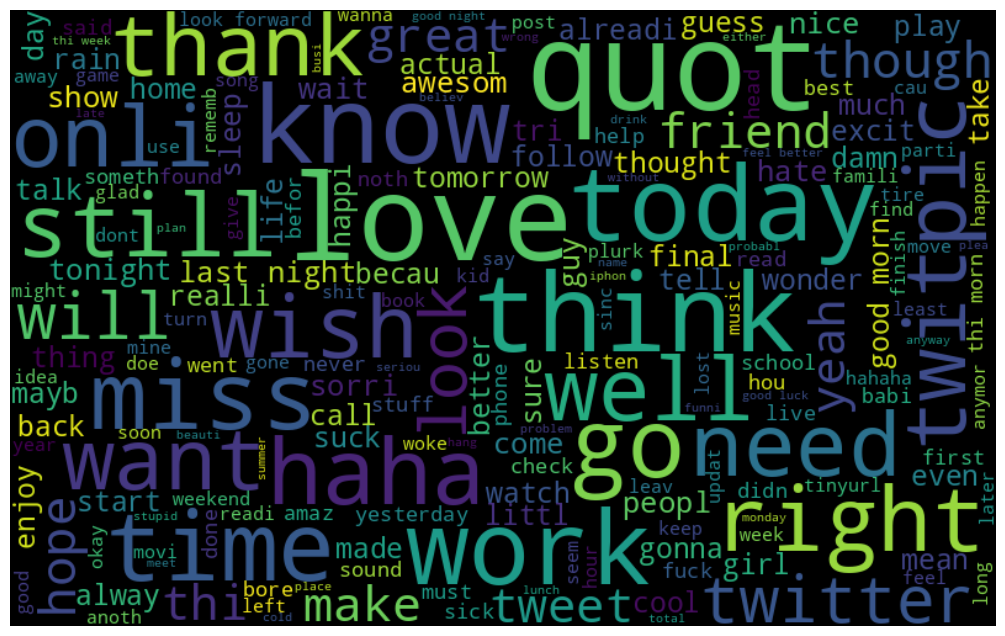

In [ ]:
# visualize the frequent words
all_words = " ".join([sentence for sentence in dataset['clean_tweet']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

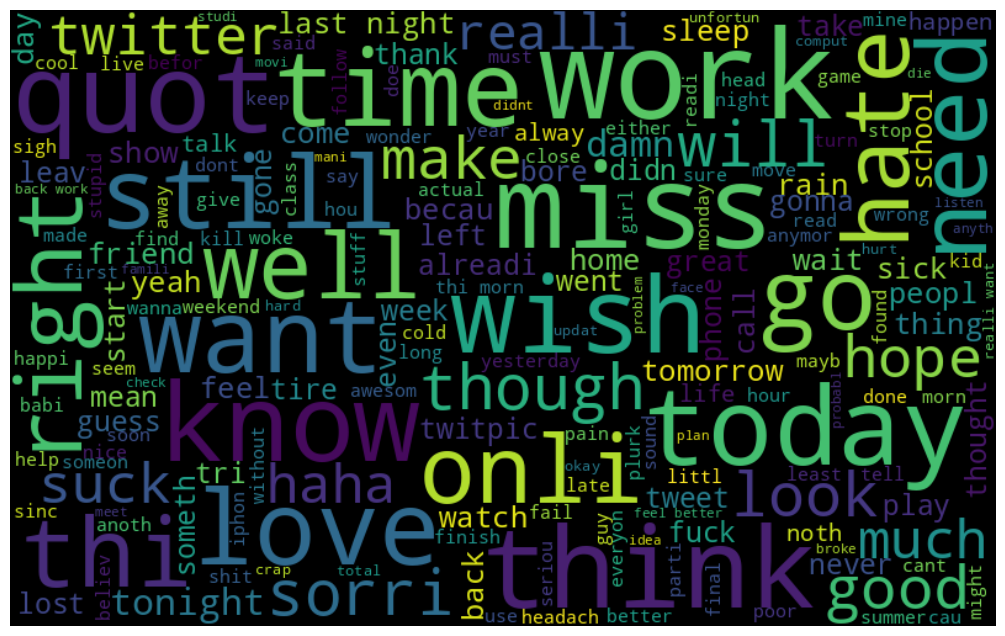

In [ ]:
# frequent words visualization for -ve
all_words = " ".join([sentence for sentence in dataset['clean_tweet'][dataset['label']==0]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

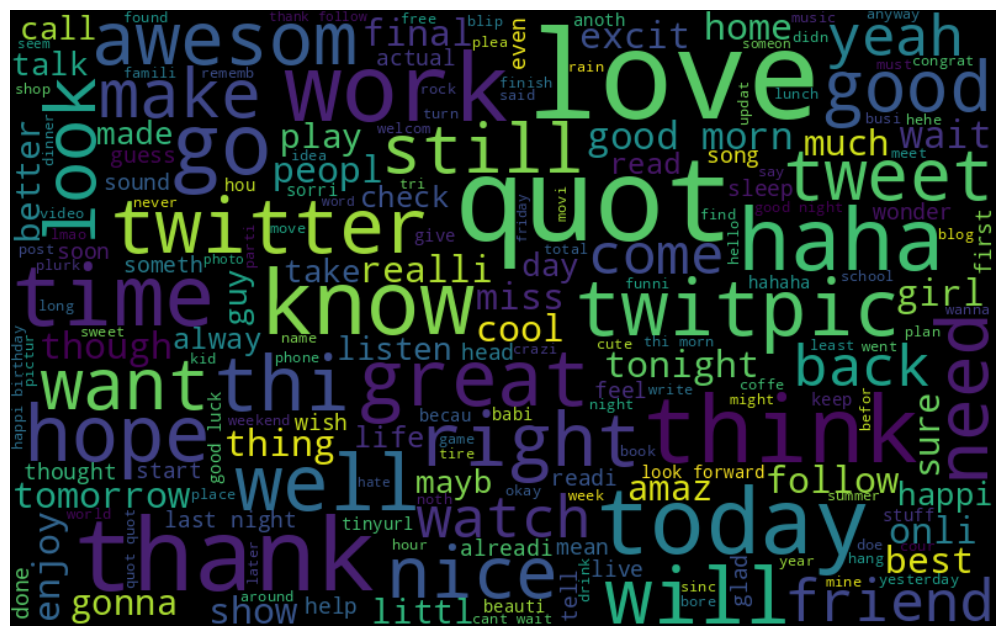

In [ ]:
# frequent words visualization for -ve
all_words = " ".join([sentence for sentence in df['clean_tweet'][df['label']==1]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Input Split

In [ ]:
# feature extraction
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(dataset['clean_tweet'])

In [ ]:
print(bow[0].toarray())
print(len(bow[0].toarray()[0]))
bow.shape

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(1599999, 1000)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(bow, dataset['label'], random_state=42, test_size=0.25)

## Model Training

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
# training
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [ ]:
# testing
pred = model.predict(x_test)
f1_score(y_test, pred)

0.744988885300097

In [ ]:
accuracy_score(y_test,pred)

0.73156

In [ ]:
# use probability to get output
pred_prob = model.predict_proba(x_test)
pred = pred_prob[:, 1] >= 0.3
pred = pred.astype(np.int)

f1_score(y_test, pred)

0.742580868334044

In [ ]:
accuracy_score(y_test,pred)

0.68001

In [ ]:
pred_prob[0][1] >= 0.3

False